In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('Hotel Reservations.csv')

In [3]:
print(df.head())

  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

No missing data, no duplicates

##EDA

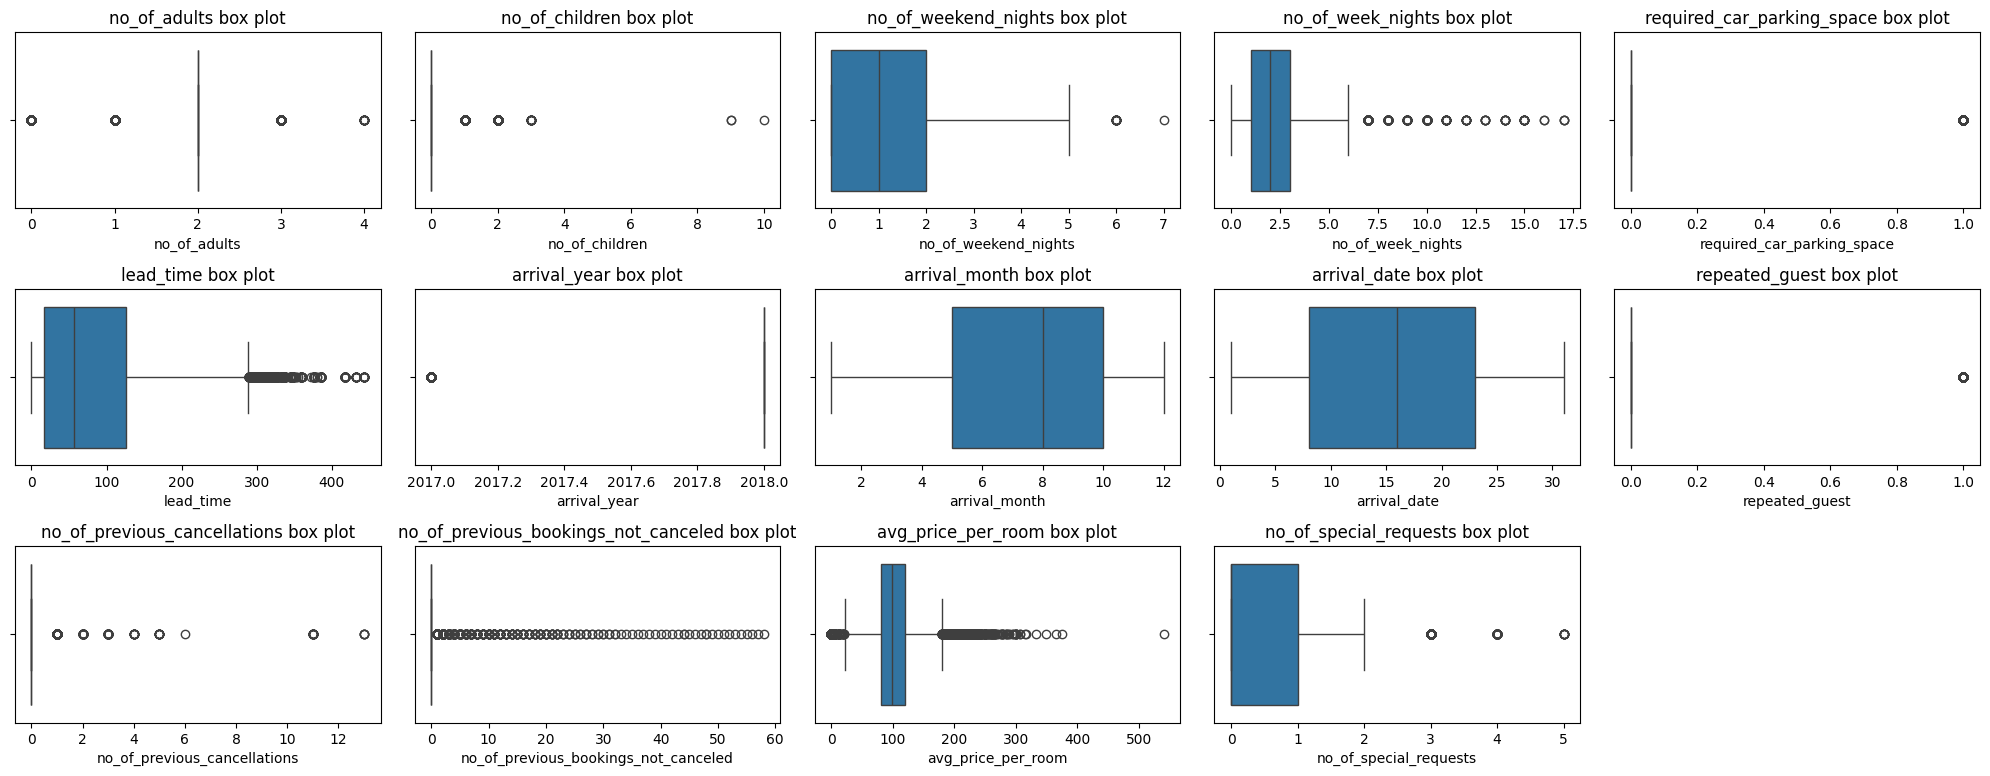

In [5]:
# Select numeric columns for detecting outliers
numeric_df = df.select_dtypes(include = ['number'])

# Use boxplot to visualize outliers for better understanding
plt.figure(figsize = (20, 10))
for index, column in enumerate(numeric_df.columns):
    plt.subplot(4, 5, index + 1)
    sns.boxplot(x = numeric_df[column])
    plt.title(f'{column} box plot')

plt.tight_layout()
plt.show()

Looking at these box plots you can see that although there are some outliers in the data, it is possible that they are special cases, **e.g**. :

there is a room occupied by 8 children, but  considering that it might be a large family with eight children or some school travel plans

some people booking rooms for many nights, possibly long term customers, etc. that

It has some significance and should not be easily deleted.
So for the time being, nothing will be done about it.

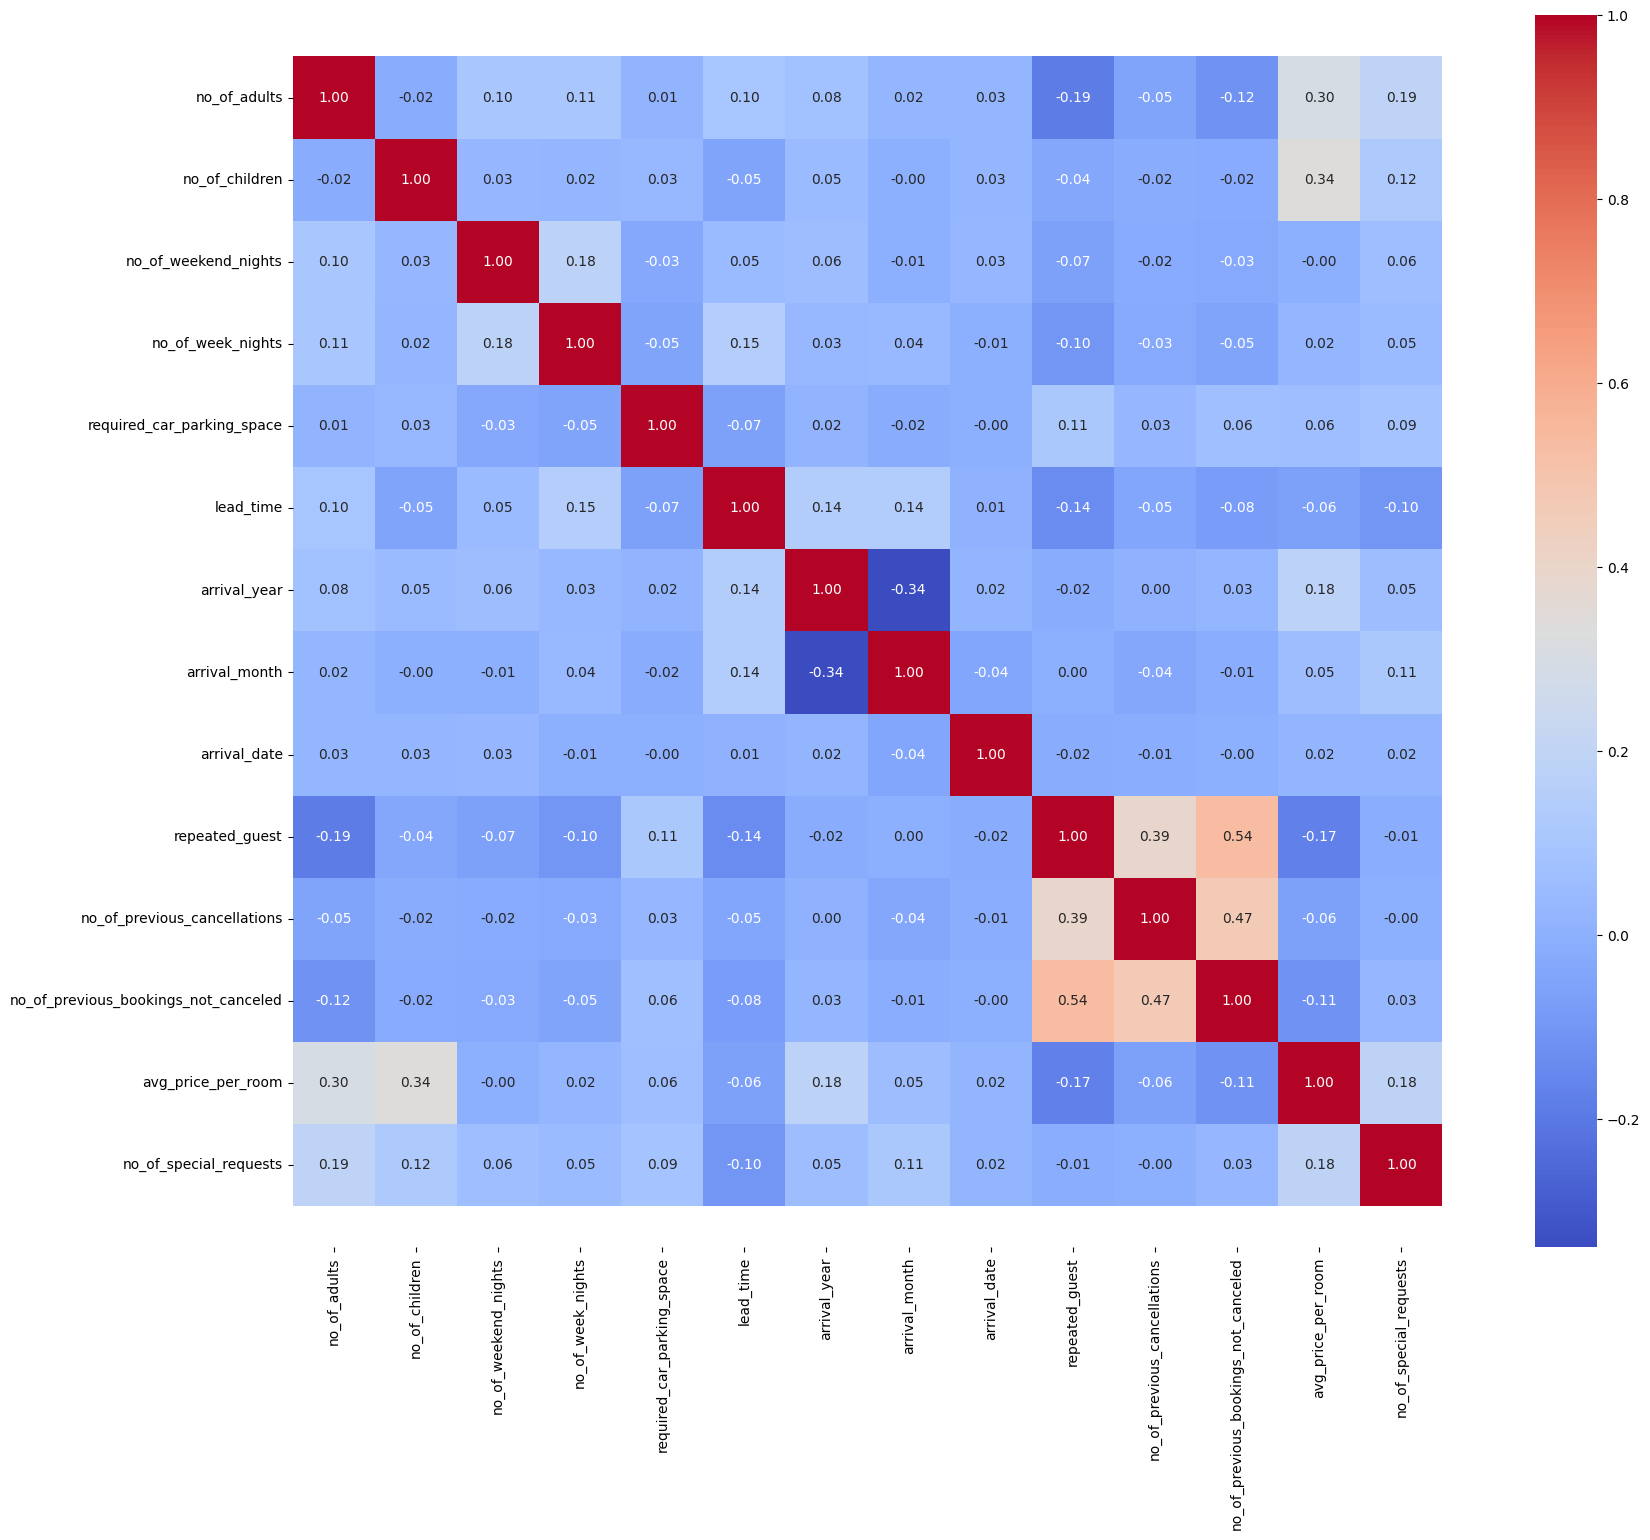

In [6]:
# Select numeric columns for correlation
numeric_df = df.select_dtypes(include = ['number'])

# Create correlation matrix
plt.figure(figsize=(24, 16))
corr_matrix = numeric_df.corr()

ax = sns.heatmap(corr_matrix, square = True, annot = True, fmt = '.2f', cmap = 'coolwarm')

# Rotate x-axis tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

# Adjust the y-axis limits to avoid visual issues
ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
plt.show()

Booking related variables such as ‘no_of_previous_bookings_not_canceled “ and ”repeated_guest’ have a strong positive correlation between them, indicating that customers with a history of not cancelling their bookings are more likely to be repeat customers.

There is a significant negative correlation between ‘no_of_previous_cancellations’ and ‘no_of_previous_bookings_not_canceled’, which is consistent with common sense.

In [7]:
# Define the plot_countplot function to reduce redundant code
def plot_countplot(subplot_index, x_col, hue_col, title, data, hue = False) -> None:
    """
    Plot a count plot on a specified subplot in a 4x2 grid layout.

    Parameters:
    subplot_index : int
        The index of the subplot in a grid layout.

    x_col : str
        The column name in the dataframe that will be used for the x-axis.

    hue_col : str
        The column name used for color encoding  when `hue` is True.

    title : str
        The title of the subplot.

    data : pd.DataFrame
        The dataframe containing the data to be plotted.

    hue : bool
        If True, the hue_col will be used to color encode the plot, default is False.

    Returns:
    None
    """
    # Activate subplot
    plt.subplot(4, 2, subplot_index)
    plt.gca().set_title(title)

    if hue:
        sns.countplot(x=x_col, hue=hue_col, edgecolor='black', alpha=0.7, data=data)
    else:
        sns.countplot(x=x_col, edgecolor='black', alpha=0.7, data=data)

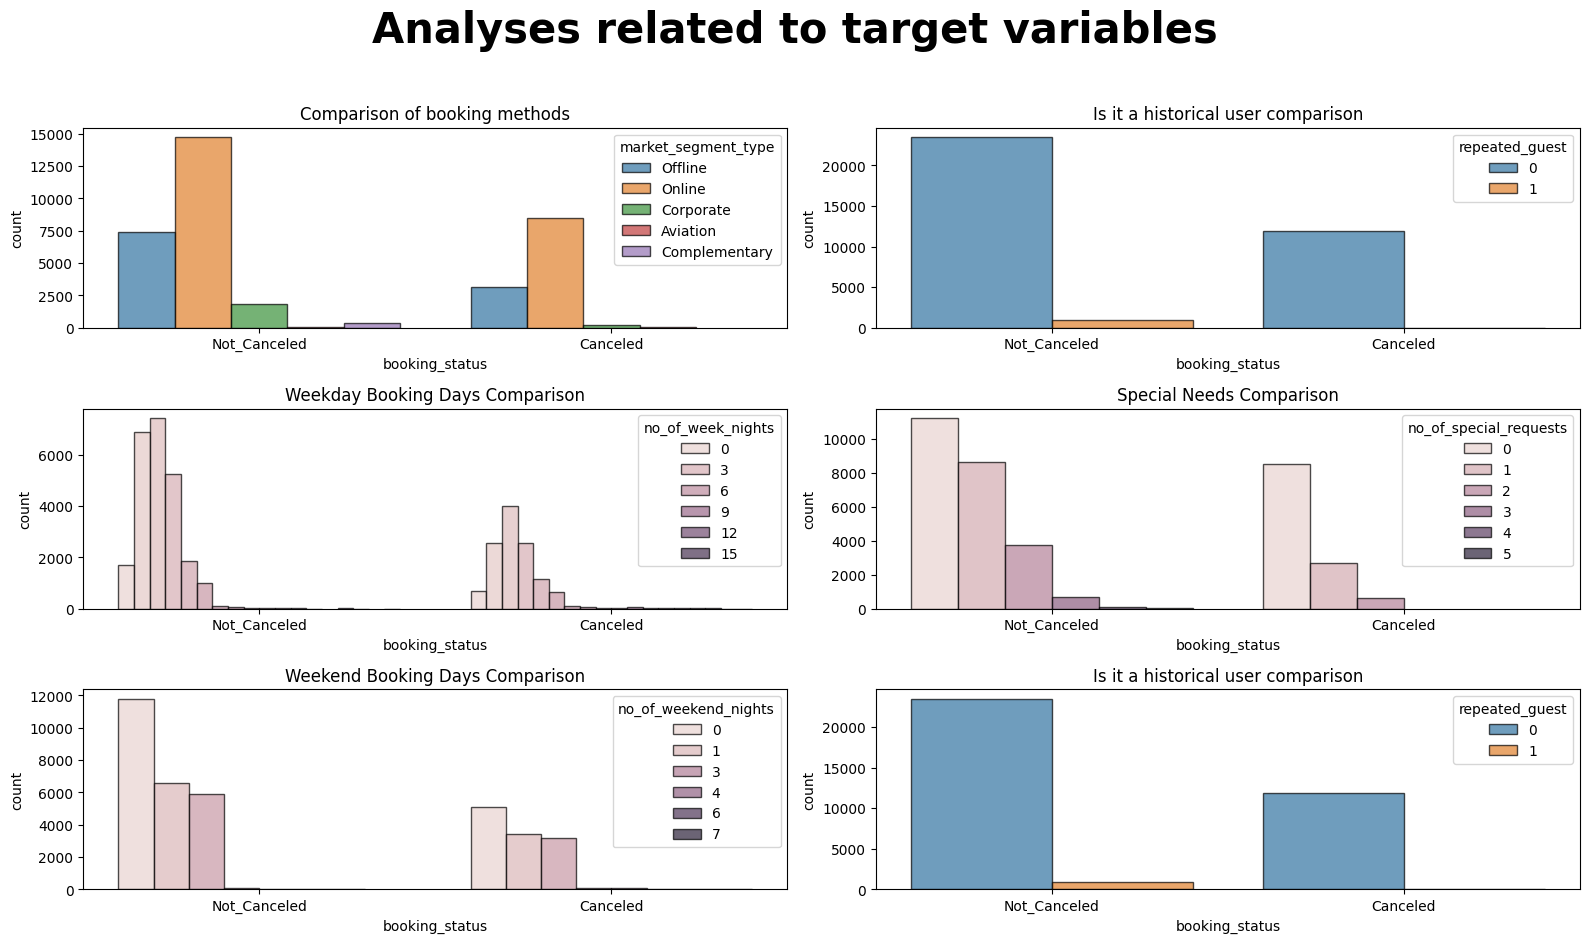

In [8]:
plt.figure(figsize=(16, 12))
plt.suptitle("Analyses related to target variables", fontweight = "bold", fontsize = 30)

# Comparison of booking methods
plot_countplot(1, 'booking_status', 'market_segment_type', 'Comparison of booking methods', df, hue = True)
# Is it a historical user comparison
plot_countplot(2, 'booking_status', 'repeated_guest', 'Is it a historical user comparison', df, hue = True)
# Weekday Booking Days Comparison
plot_countplot(3, 'booking_status', 'no_of_week_nights', 'Weekday Booking Days Comparison', df, hue = True)
# Special Needs Comparison
plot_countplot(4, 'booking_status', 'no_of_special_requests', 'Special Needs Comparison', df, hue = True)
# Comparison of weekend bookings
plot_countplot(5, 'booking_status', 'no_of_weekend_nights', 'Weekend Booking Days Comparison', df, hue = True)
# Is it a historical user comparison
plot_countplot(6, 'booking_status', 'repeated_guest', 'Is it a historical user comparison', df, hue = True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--As we can see from the graph above, customers with special needs tend to be more stable, historical users show higher booking success rates, bookings for shorter or no weekend days are more likely to be cancelled, while bookings for 1 or 3 days are more stable, market segment type 4 is more likely to be successful, etc.

--Indicates: Historical users and customers with special needs are more likely to book successfully The number of days booked on weekdays and weekends is strongly correlated with booking success, with shorter bookings being more likely to be cancelled. The market segment types show that certain types of customers are more likely to make successful bookings.


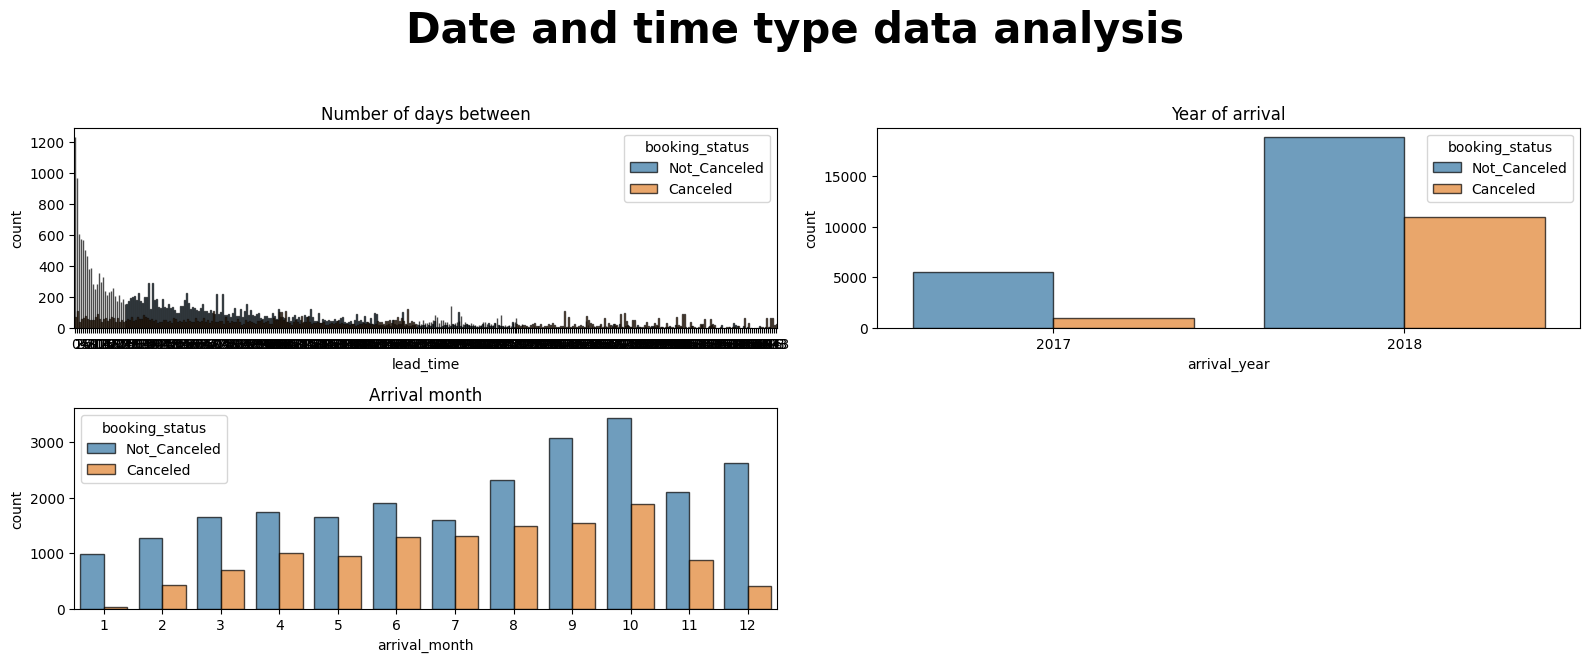

In [9]:
plt.figure(figsize=(16, 12))
plt.suptitle("Date and time type data analysis", fontweight = "bold", fontsize = 30)

# Number of days between
plot_countplot(1, 'lead_time', 'booking_status', 'Number of days between', df,hue = True)
# Year of arrival
plot_countplot(2, 'arrival_year', 'booking_status', 'Year of arrival', df,hue = True)
# Arrival month
plot_countplot(3, 'arrival_month', 'booking_status', 'Arrival month', df,hue = True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The further in advance a booking is made, the greater the chances of cancellation are likely to be; and in 2018, cancellation rates have increased. Certain months (e.g., summer and fall) see more frequent booking activity, but cancellations are also more common in those months.

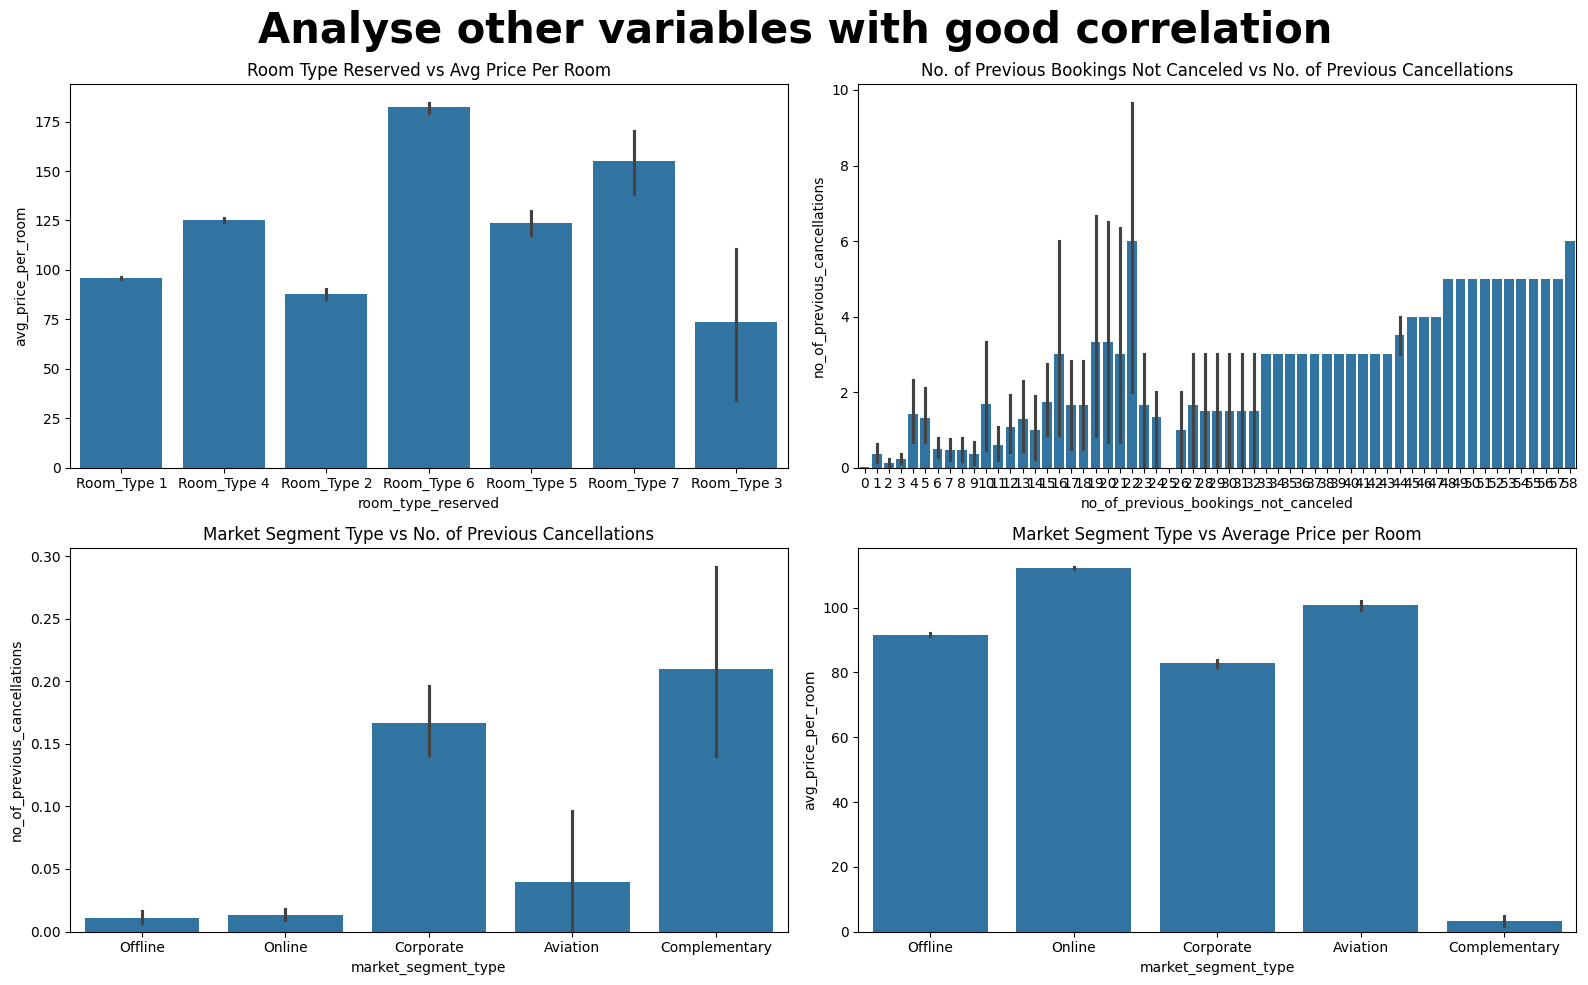

In [10]:
plt.figure(figsize=(16, 10))
plt.suptitle("Analyse other variables with good correlation", fontweight = "bold", fontsize = 30)
# Room Type Reserved vs Avg Price Per Room
plt.subplot(2, 2, 1)
sns.barplot(x='room_type_reserved', y='avg_price_per_room', data=df)
plt.title('Room Type Reserved vs Avg Price Per Room')

# No. of Previous Bookings Not Canceled vs No. of Previous Cancellations
plt.subplot(2, 2, 2)
sns.barplot(x='no_of_previous_bookings_not_canceled', y='no_of_previous_cancellations', data=df)
plt.title('No. of Previous Bookings Not Canceled vs No. of Previous Cancellations')

# Market Segment Type vs No. of Previous Cancellations
plt.subplot(2, 2, 3)
sns.barplot(x='market_segment_type', y='no_of_previous_cancellations', data=df)
plt.title('Market Segment Type vs No. of Previous Cancellations')

# Market Segment Type vs Average Price per Room
plt.subplot(2, 2, 4)
sns.barplot(x='market_segment_type', y='avg_price_per_room', data=df)
plt.title('Market Segment Type vs Average Price per Room')


plt.tight_layout()
plt.show()

--Certain room types (e.g. Room_Type 2) are much more expensive than others, while Room_Type 3 is less expensive. The hotel can adjust its pricing strategy or optimise the services of different room types by

--As the number of uncancelled bookings increases, there is a corresponding increase in the number of previous cancellations. It is possible that some customers have the habit of making repeated bookings and cancellations

--Corporate and complimentary customers have higher cancellation rates, while airline-related customers have the lowest cancellation rates. Online bookings, airline-related bookings, and corporate bookings have relatively high rates, while the complimentary category has the lowest rates.
So it is possible to focus on airline related customers

##Feature engineering

In [11]:
df = df.drop('Booking_ID', axis = 1)

In [12]:
#Label coding of specified data columns
for feat in ['type_of_meal_plan', 'room_type_reserved','market_segment_type','booking_status']:
    lbl = LabelEncoder()
    lbl.fit(df[feat])
    df[feat] = lbl.transform(df[feat])

In [13]:
X = df.drop('booking_status', axis = 1).values
y = df['booking_status']

In [14]:
#Splitting the dataset
train_data,test_data,train_target,test_target = train_test_split(X, y, test_size = 0.25, random_state = 42)

##Model training

In [15]:
def evaluate_model(model, train_data, test_data, train_target, test_target,model_name, task = 'regression') -> None:
    """
    Train a regression or classification model and compute various evaluation metrics.

    Parameters:
    model: Regression or classification models
        The model object (regressor or classifier) to be trained and evaluated.

    train_data: ndarray
        The training data features.

    test_data: ndarray
        The test data features.

    train_target: ndarray
        The true labels for the training data.

    test_target: ndarray
        The true labels for the test data.

    model_name: str
        The name of the model for output purposes.

    task: str
        The type of task, either 'regression' or 'classification', default is 'regression'.

    Returns:
    None
    """
    # Train the model
    model.fit(train_data, train_target)

    # Make predictions on the test data
    y_pred = model.predict(test_data)

    if task == 'regression':
        # Compute regression metrics
        rmse = mean_squared_error(test_target, y_pred, squared=False)
        print(f'{model_name} Regression Metrics:')
        print(f'  RMSE: {rmse}')

    elif task == 'classification':
        # Compute classification metrics
        accuracy = accuracy_score(test_target, y_pred)
        print(f'{model_name} Classification Metrics:')
        print(f'  Accuracy: {accuracy}')

    else:
        print(f'Unknown task type: {task}. Please specify "regression" or "classification".')

In [16]:
# regression models
knn_regression = KNeighborsRegressor()
tree_regression = DecisionTreeRegressor()
svr_regression = SVR()
lin_regression = LinearRegression()

# Call the function for regression tasks
evaluate_model(knn_regression, train_data, test_data, train_target, test_target, "KNN")
evaluate_model(tree_regression, train_data, test_data, train_target, test_target, "Decision Tree")
evaluate_model(svr_regression, train_data, test_data, train_target, test_target, "SVR")
evaluate_model(lin_regression, train_data, test_data, train_target, test_target, "Linear Regression")

KNN Regression Metrics:
  RMSE: 0.3703297413424256
Decision Tree Regression Metrics:
  RMSE: 0.3602081612492413
SVR Regression Metrics:
  RMSE: 0.4335573180819427
Linear Regression Regression Metrics:
  RMSE: 0.3876987502231685


In [17]:
# classification models
knn_classification = KNeighborsClassifier()
tree_classification = DecisionTreeClassifier()
svm_classification = SVC()
log_regression = LogisticRegression()

# Call the function for classification tasks
evaluate_model(knn_classification, train_data, test_data, train_target, test_target, "KNN", task='classification')
evaluate_model(tree_classification, train_data, test_data, train_target, test_target, "Decision Tree", task='classification')
evaluate_model(svm_classification, train_data, test_data, train_target, test_target, "SVM", task='classification')
evaluate_model(log_regression, train_data, test_data, train_target, test_target, "Logistic Regression", task='classification')

KNN Classification Metrics:
  Accuracy: 0.8091300033079722
Decision Tree Classification Metrics:
  Accuracy: 0.8673503142573602
SVM Classification Metrics:
  Accuracy: 0.7606130775168155
Logistic Regression Classification Metrics:
  Accuracy: 0.783438085786746


In the classification task, the decision tree classifier has the highest accuracy. The SVM had the lowest accuracy. However, it is worth noting that the performance of the model may be improved by further hyperparameter tuning or adjustment.

For the regression task, the decision tree regression had the lowest RMSE, while SVR regression had the highest RMSE.

Taken together, the decision tree appears to perform favorably in both classification accuracy and regression RMSE for the specific conditions of this dataset. However, these results do not necessarily imply that decision trees will always be the best model across all datasets and tasks. Future work could explore different parameter settings  to further validate these findings.